#  DIPLS Model Selection with GridSearchCV
## Dr. Ramin Nikzad-Langerodi
### Bottleneck Analytics GmbH
info@bottleneck-analytics.com

___

In [1]:
# Install required libraries
#!pip install scikit-learn diplslib pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.utils.estimator_checks import check_estimator
from diPLSlib.models import DIPLS, GCTPLS
from diPLSlib.utils.misc import rmse as r_mse
from sklearn.metrics import make_scorer

### Data Set

In what follows we will use the Melamine benchmark dataset for domain adaptation. The dataset consists of NIR spectra of 4 different kinds of melamine along with the turbidity of the samples during a polymerization reaction. The dataset is available at the following link: https://github.com/RNL1/Melamine-Dataset.

We start by preparing source and target domain datasets. 

In [2]:
# Load and read the data
url = "https://github.com/RNL1/Melamine-Dataset/blob/master/Melamine_Dataset.pkl?raw=true"
data = pd.read_pickle(url)

wn1 = data['wn1']
wn2 = data['wn2']
w = np.hstack((wn1, wn2))

Xs = np.hstack((data['R862']['X1'], data['R862']['X2']))
Xt = np.hstack((data['R861']['X1'], data['R861']['X2']))

ys = data['R862']['Y']
yt = data['R861']['Y']

Let's plot the spectra.

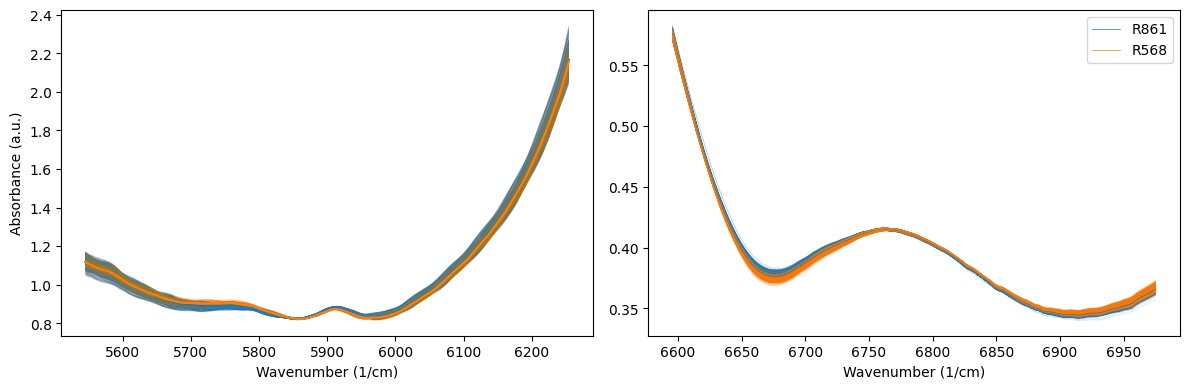

In [3]:
# Plot the data
f, ax = plt.subplots(1,2,figsize=(12, 4))
ax[0].plot(wn1,data['R861']['X1'].T,color="#1f77b4",linewidth=0.03,linestyle=':')
ax[0].plot(wn1,data['R568']['X1'].T,color="#ff7f0e",linewidth=0.03,linestyle=':')

s, = ax[0].plot(wn1,np.mean(data['R861']['X1'],axis=0),color="#1f77b4",label='Source')
t, = ax[0].plot(wn1,np.mean(data['R568']['X1'],axis=0),color="#ff7f0e",label='Target')

ax[0].set_ylabel('Absorbance (a.u.)')
ax[0].set_xlabel('Wavenumber (1/cm)')

ax[1].plot(wn2,data['R861']['X2'].T,color="#1f77b4",linewidth=0.1,linestyle=':')
ax[1].plot(wn2,data['R568']['X2'].T,color="#ff7f0e",linewidth=0.1,linestyle=':')
ax[1].set_xlabel('Wavenumber (1/cm)')

s, = ax[1].plot(wn2,np.mean(data['R861']['X2'],axis=0),linewidth=0.5,color="#1f77b4",label='Source')
t, = ax[1].plot(wn2,np.mean(data['R568']['X2'],axis=0),linewidth=0.5,color="#ff7f0e",label='Target')

plt.legend([s,t], ['R861', 'R568'])
plt.tight_layout()

### Optimization of the DIPLS parameters

#### Number of latent variables (LVs) 
We start with optimization of the number of LVs. We will use the GridSearchCV method from the scikit-learn library for the optimization.

In [38]:
# Tune the number of LVs
param_grid = {'A': np.arange(1, 15)}

# Intialize the DIPLS model 
dipls = DIPLS(rescale='Source')

# Tune the number of LVs with the root mean squared error as the scoring metric
grid_search = GridSearchCV(dipls, param_grid, cv=5, scoring= 'neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(Xs, ys)

# Print the best parameters and best score for each scorer
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'A': np.int64(12)}


Let's plot the results of the optimization.

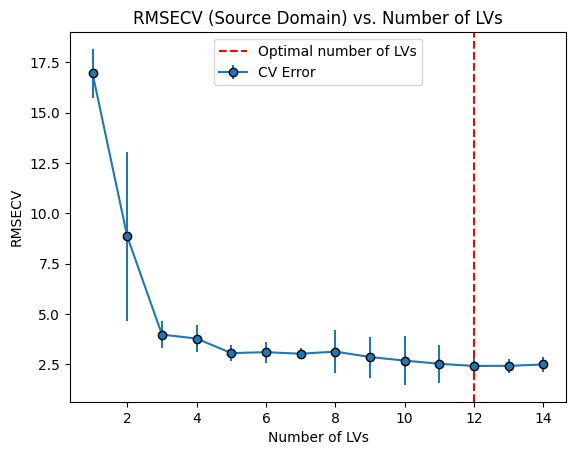

In [41]:
# Plot MSE vs number of LVs
opt_A = grid_search.best_params_['A']
rmse = -grid_search.cv_results_['mean_test_score']
rmse_std = grid_search.cv_results_['std_test_score']
plt.errorbar(param_grid['A'], rmse, yerr=rmse_std, fmt='-o', mec='k', label='CV Error')
plt.gca().axvline(opt_A, color='r', linestyle='--', label='Optimal number of LVs')
plt.xlabel('Number of LVs')
plt.ylabel('RMSECV')
plt.title('RMSECV (Source Domain) vs. Number of LVs')
plt.legend()
plt.show()

#### Regularization parameter l
We now fix the number of LVs to 10 (close to the minimum) and tune the regularization parameter unsing the GridSearchCV method.

We also define a custom scorer function to evaluate the discrepancy between the distributions of source and target domain scores as we change the regularization parameter. 

In [42]:
# Intialize the DIPLS model 
dipls = DIPLS(A=10)

# Define the parameter grid for GridSearchCV
param_grid = {
    'l': np.logspace(5, 11, 10),
}

# Define a custom scorer for discrepancy
def discrepancy_scorer(estimator, X, y, **kwargs):
    return -np.mean(estimator.discrepancy_)

# Add the custom scorer to the GridSearchCV
grid_search = GridSearchCV(estimator=dipls, param_grid=param_grid, cv=10, scoring={'discrepancy': discrepancy_scorer, 'neg_rmse': 'neg_root_mean_squared_error'}, refit='neg_rmse', n_jobs=-1)
grid_search.fit(Xs, ys, **{'xs': Xs, 'xt': Xt})

# Print the best parameters and best score for each scorer
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'l': np.float64(4641588833.612773)}


Let's plot the results of the optimization.

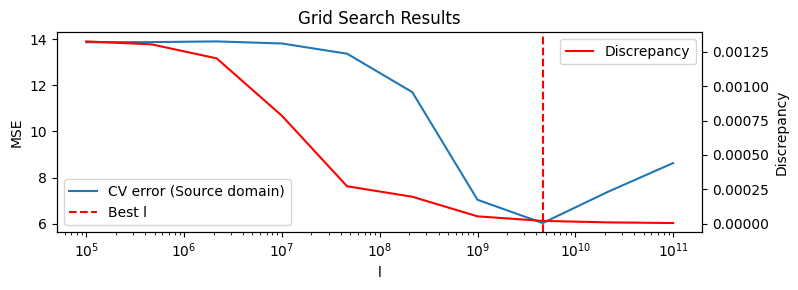

In [43]:
# Plot parameter grid search results
discrepancy = -grid_search.cv_results_['mean_test_discrepancy'].reshape(len(param_grid['l']))
mse = -grid_search.cv_results_['mean_test_neg_rmse'].reshape(len(param_grid['l']))

plt.figure(figsize=(8, 3))
plt.plot(param_grid['l'], mse, label='CV error (Source domain)')
plt.gca().axvline(x=grid_search.best_params_['l'], color='r', linestyle='--', label='Best l')
plt.xlabel('l')
plt.ylabel('MSE')
plt.title('Grid Search Results')
plt.xscale('log')
plt.legend(loc='lower left')

plt.twinx()
plt.plot(param_grid['l'], discrepancy, label='Discrepancy', color='r')
plt.xlabel('l')
plt.ylabel('Discrepancy')
plt.xscale('log')
plt.legend()

plt.tight_layout()

As expected the discrepancy (red) decreases as we increase the regularization parameter. At the same time we observe that the Mean Squared Error (MSE) of cross-validation in the source domain (blue) decreases. The optimal regularization parameter (according to the criterion of minimizing source domain CV error) is around 4e9.

We proceed by fitting the DIPLS model with the optimal regularization parameter and use it to make predictions on the target domain spectra. We also compare the results with a PLS model trained on the source domain only.

PLS RMSECV (Source): 2.93
PLS RMSEP (Target): 4.75
DIPLS RMSEP (Target): 3.97


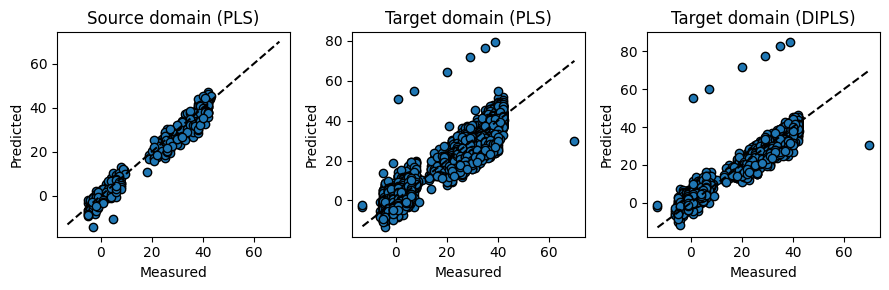

In [45]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
# Cross-validated prediction in the source domain (w/o regualrization)
dipls = DIPLS(A=10,  l=0, rescale='Source')
dipls.fit(Xs, ys, **{'xs': Xs, 'xt': Xt})
y_pred = cross_val_predict(dipls, Xs, ys, cv=5)
plt.scatter(ys, y_pred, edgecolors='k')
plt.plot([np.min(yt), np.max(yt)], [np.min(yt), np.max(yt)], 'k--')
print(f"PLS RMSECV (Source): {r_mse(y_pred.T, ys.T):.2f}")
plt.title('Source domain (PLS)')
plt.xlabel('Measured')
plt.ylabel('Predicted')

# Predict target domain data (w/o regualrization)
plt.subplot(1, 3, 2)
dipls = DIPLS(A=10,  l=0)
dipls.fit(Xs, ys, **{'xs': Xs, 'xt': Xt})
yt_pred = dipls.predict(Xt)
plt.scatter(yt, yt_pred, edgecolors='k')
plt.plot([np.min(yt), np.max(yt)], [np.min(yt), np.max(yt)], 'k--')
print(f"PLS RMSEP (Target): {r_mse(yt_pred.T, yt.T):.2f}")
plt.title('Target domain (PLS)')
plt.xlabel('Measured')
plt.ylabel('Predicted')

# Predict target domain data (with optimal regualrization)
plt.subplot(1, 3, 3)
dipls = DIPLS(A=10,  l=grid_search.best_params_['l'])
dipls.fit(Xs, ys, **{'xs': Xs, 'xt': Xt})
yt_pred = dipls.predict(Xt)
plt.scatter(yt, yt_pred, edgecolors='k')
plt.plot([np.min(yt), np.max(yt)], [np.min(yt), np.max(yt)], 'k--')
print(f"DIPLS RMSEP (Target): {r_mse(yt_pred.T, yt.T):.2f}")
plt.title('Target domain (DIPLS)')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.tight_layout()

The PLS model works reasonably well on the source domain (left) but gives significantly worse predicitons on the target domain spectra (middle). The DIPLS model with optimal regularization performs much better on the target domain spectra (right). Note that we have a couple of outliers in the target domain, too...

Let's next explore in more detail the relationship between source/target domain error and discrepancy:

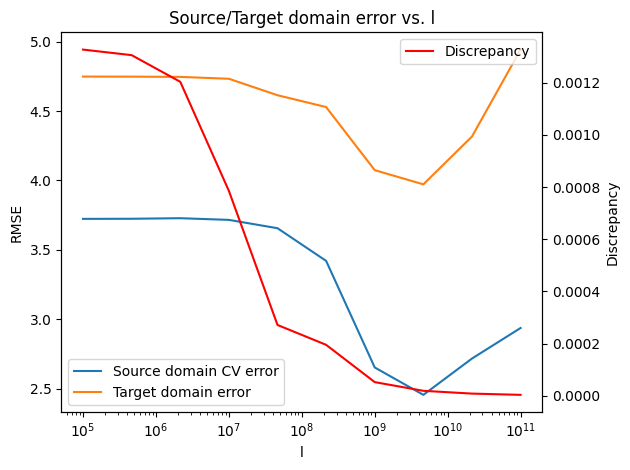

In [46]:
# Loop over different values of l
RMSE = []
for l in np.logspace(5, 11, 10):
    dipls = DIPLS(A=10,  l=l)
    dipls.fit(Xs, ys, **{'xs': Xs, 'xt': Xt})
    yt_pred = dipls.predict(Xt)
    RMSE.append(r_mse(yt_pred.T, yt.T))

plt.plot(param_grid['l'], np.sqrt(mse), label='Source domain CV error')
plt.plot(np.logspace(5, 11, 10), RMSE, label="Target domain error")
plt.xscale('log')
plt.xlabel('l')
plt.ylabel('RMSE')
plt.title('Source/Target domain error vs. l')
plt.legend()
plt.twinx()
plt.plot(param_grid['l'], discrepancy, label='Discrepancy', color='r')
plt.ylabel('Discrepancy')
plt.legend()
plt.tight_layout()

We can see that the source and target domain errors move in the same direction as we increase the regularization. On the other hand, when we see an increase of source domain error upon regularization, this often indicates that the model is not going to generalize well to the target domain.  